<a href="https://colab.research.google.com/github/NRafif/Machine-Learning/blob/main/CNN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARY

In [1]:
from google.colab import files    # Untuk upload files
import zipfile                    # Untuk unzip file
import os                         # Untuk interaksi dengan os
import matplotlib.pyplot as plt   # Untuk visualisasi data
import matplotlib.image as mpimg  # Membaca dan memanipulasi gambar
from google.colab import drive    # Untuk mengakses google drive
import tensorflow as tf           # Library utama untuk Machine learning
import numpy as np                # Library untuk komputasi numerik

In [2]:
# Mount google drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [3]:
batch_size = 32
img_height = 224
img_width = 224

# PERSIAPAN DATASET


Mengambil dataset dari kaggle

In [4]:
!pip install -q Kaggle

In [5]:
uploaded = files.upload()

In [6]:
!mkdir -p ~/.kaggle                #membuat folder .kaggle di root
!mv kaggle.json ~/.kaggle/         #memindahkan file kaggle.json ke folder ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json   #merubah permission file kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [7]:
!kaggle datasets download -d adityavahreza/cat-skin-disease

Dataset URL: https://www.kaggle.com/datasets/adityavahreza/cat-skin-disease
License(s): unknown
 97% 19.0M/19.6M [00:01<00:00, 19.2MB/s]
100% 19.6M/19.6M [00:01<00:00, 10.5MB/s]


Load Dataset


In [8]:
# Extract zipfile
! unzip "/content/cat-skin-disease.zip" -d.

Archive:  /content/cat-skin-disease.zip
  inflating: ./CAT SKIN DISEASE/Health/04ab5725b230e3d3e76031f9cf1c95f9_jpg.rf.405ef84073960c0085b2018d77d0375e.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0bc984c93228017f4727e0c852126f7d_jpg.rf.bf7d7a91fa42774fa38b03cbcf58c5c1.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0f210d552b92c7204442138de5151b55_jpg.rf.aae8a1537e4f29b4c09fce3c0a4091e7.jpg  
  inflating: ./CAT SKIN DISEASE/Health/15a8e5d7bc0011c973b3fa37e490bd7a_jpg.rf.c45bdc80a9bcd5b6655b586ed3f3fc48.jpg  
  inflating: ./CAT SKIN DISEASE/Health/1e161cf3433aee7231b8b56333127e5c_jpg.rf.a39934baa8d1de7b2e4d01a9c404bcb1.jpg  
  inflating: ./CAT SKIN DISEASE/Health/20d4646247bd7033d6d76f64566f0052_jpg.rf.219ac65aabce12bf7c00ff09bb2bc9d3.jpg  
  inflating: ./CAT SKIN DISEASE/Health/26da1f8b744ccff35a3cba4026407b9d_jpg.rf.2abec213f35d42b8b46604a65cc38956.jpg  
  inflating: ./CAT SKIN DISEASE/Health/2b9be78add42a048bc7cca3afee5ca6c_jpg.rf.dc9218d7696d506344ffadfec4bf4e2a.jpg  
  inflating: ./C

Menentukan class

In [9]:
cat_disease = "/content/CAT SKIN DISEASE"
cat_disease_classes = os.listdir(cat_disease)

In [10]:
print("Cat Skin Disease Class :")
for class_name in cat_disease_classes:
  if os.path.isdir(os.path.join(cat_disease, class_name)):
    print(class_name)

Cat Skin Disease Class :
Ringworm
Lepra
Scabies
Health


Preview Gambar


Ringworm
Total Image :  103
Resolusi Gambar :  (640, 640, 3)


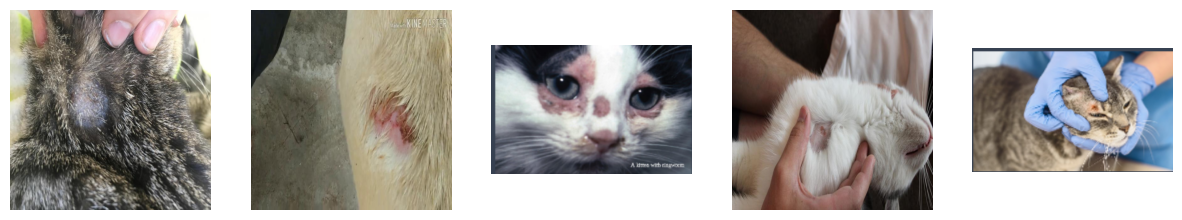


Lepra
Total Image :  100
Resolusi Gambar :  (224, 224, 3)


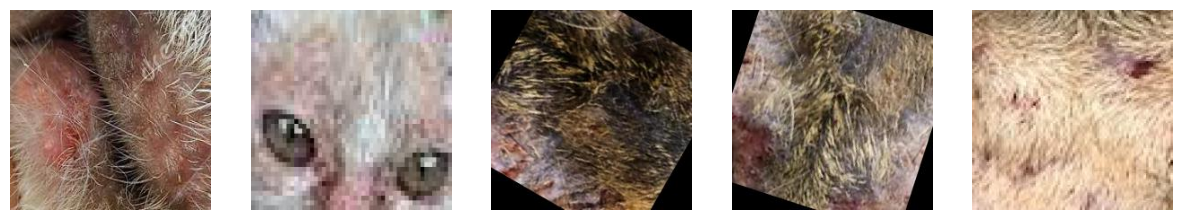


Scabies
Total Image :  109
Resolusi Gambar :  (387, 544, 3)


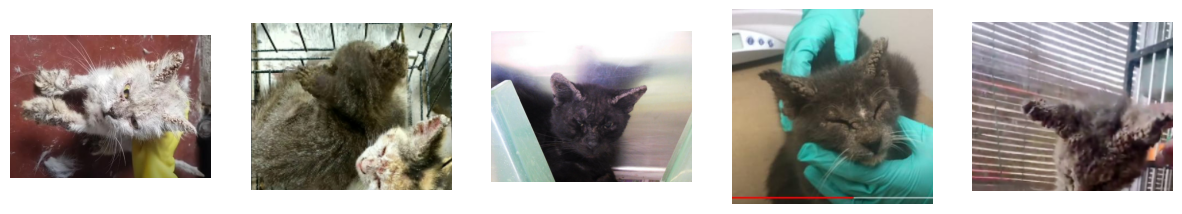


Health
Total Image :  99
Resolusi Gambar :  (640, 640, 3)


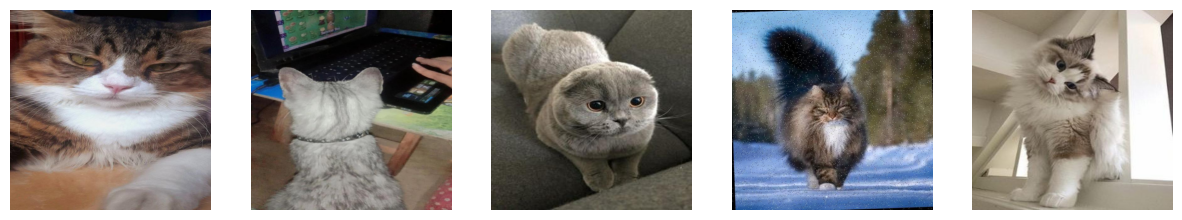

In [11]:
for item in cat_disease_classes:
    print("")
    print(item)
    class_dir = os.path.join(cat_disease, item)
    class_images = [img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Menghitung total image di setiap kelas
    num_images = len(class_images)
    print("Total Image : ", num_images)

    # Menghitung resolusi pada gambar pertama
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolusi Gambar : ", image_shape)

    # Menampilkan beberapa gambar
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(class_images))):  # Tampilkan maksimum 5 gambar atau sesuai jumlah yang tersedia
        sp = plt.subplot(1, 5, i + 1)
        img = mpimg.imread(os.path.join(class_dir, class_images[i]))
        plt.axis('off')
        plt.imshow(img)
    plt.show()


# PREPOCESING DATA


Split data

In [12]:
def train_val_Dataset():
  training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
      cat_disease,
      image_size=(img_height, img_width),
      color_mode='rgb',
      batch_size= batch_size,
      label_mode='categorical',
      validation_split=0.2,
      subset='both',
      seed=42
  )

  return training_dataset, validation_dataset

In [13]:
# Membuat dataset
training_dataset, validation_dataset = train_val_Dataset()

Found 411 files belonging to 4 classes.
Using 329 files for training.
Using 82 files for validation.


In [14]:
# Melihat batch pertama dari image dan labels
for image_batch, labels_batch in training_dataset.take(1):
  example_batch = image_batch
  labels_batch = labels_batch

  print(f"maximum pixel value of images : {np.max(example_batch)}.\n")
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")

maximum pixel value of images : 255.0.

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 4)


Augmentation

In [25]:
def create_augmentation_model():
  augmentation_model = tf.keras.Sequential([
      tf.keras.Input(shape=(224, 224, 3)),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.2),
      tf.keras.layers.RandomContrast(0.2),
  ])

  return augmentation_model


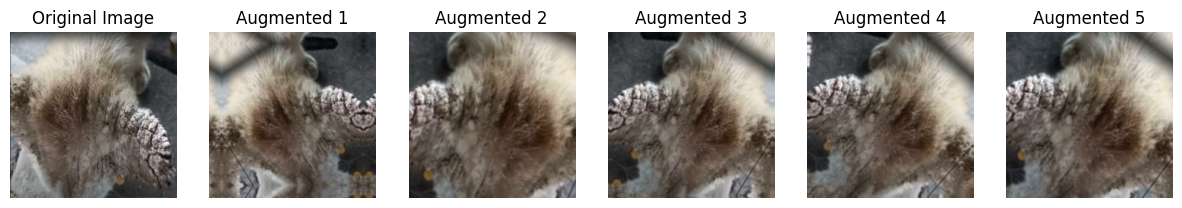

In [26]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch[0])

images = [sample_image]

# Apply random augmentation 5 times
for _ in range(5):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3','Augmented 4','Augmented 5']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

# MODELING

In [32]:
def create_model():

  augmentation_layers = create_augmentation_model()

  model = tf.keras.models.Sequential([
      augmentation_layers,

      # Rescahling input shape
      tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

      # Convolutional and pooling layers
      tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      # Flatten and dense layer
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.3),

      # Output layers
      tf.keras.layers.Dense(4, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )


  return model

In [33]:
create_model().summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_11 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 109, 109, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │       1,384,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,482,564 (5.66 MB)

 Trainable params: 1,482,564 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

Buat fungsi callback

In [34]:
class early_stopping_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy')>=0.85 and logs.get('val_accuracy')>=0.9:
      print("\nReached 85% train accuracy and 90% accuracy so cancelling training!")
      self.model.stop_training = True

Mulai train model

In [35]:
history = create_model().fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping_callback()]
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.2248 - loss: 1.4571 - val_accuracy: 0.2439 - val_loss: 1.3823
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.2412 - loss: 1.3919 - val_accuracy: 0.3171 - val_loss: 1.3819
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.2531 - loss: 1.3801 - val_accuracy: 0.4268 - val_loss: 1.3832
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.2613 - loss: 1.3920 - val_accuracy: 0.2317 - val_loss: 1.3851
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.2692 - loss: 1.3842 - val_accuracy: 0.3171 - val_loss: 1.3813
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.2812 - loss: 1.3871 - val_accuracy: 0.3171 - val_loss: 1.3744
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.2714 - loss: 1.3920 - val_accuracy: 0.3537 - val_loss: 1.3751
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.3084 - loss: 1.3832 - val_accu

# Hasil Model

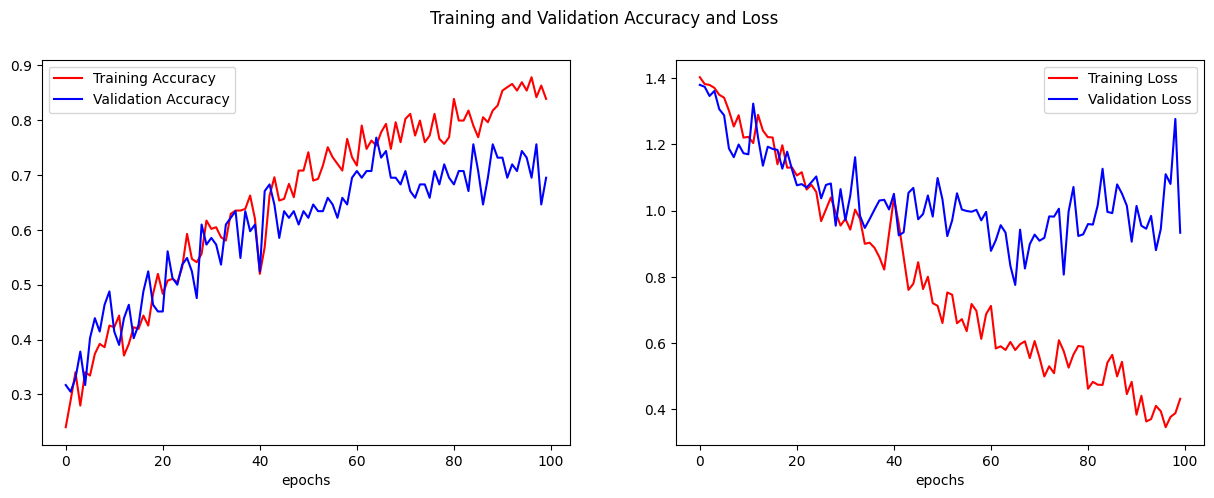

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Accuracy and Loss')

# Define data and labels for each subplot
data_labels = [
    (acc, val_acc, 'Accuracy'),
    (loss, val_loss, 'Loss')
]

# Iterate through subplots and data
for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    axs[i].plot(epochs_range, data[0], 'r', label="Training " + label)
    axs[i].plot(epochs_range, data[1], 'b', label="Validation " + label)
    axs[i].legend()
    axs[i].set_xlabel('epochs')

plt.show()